<a href="https://colab.research.google.com/github/jordan-bonev/Fantasy-Premier-League-Points-Prediction/blob/main/Fantasy-Premier-League-Points-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
%matplotlib inline

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Fantasy Premier League Points Prediction

## Problem Definition

Fantasy Premier League is an online multipalyer game based on the English Premier League. It is the most famous fantasy game in the world. The aim of it is to build the squad that will bring you the most points every game week. Points are awarded for goals scored, assists, clean sheets, minutes played etc.

The objective of this project is to predict the points that every player will score next game week - in that way we could make an informed decision which players to include in our squad.

The positions of the 15 players that could be selected are presented down below:

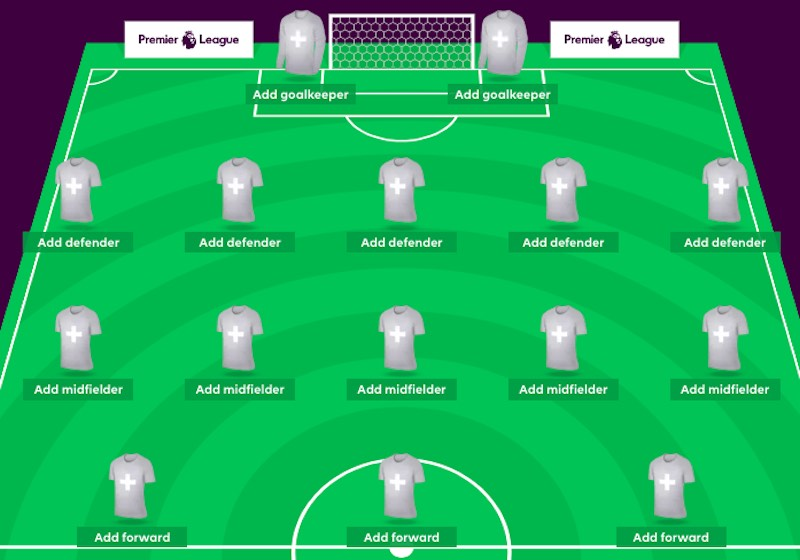

In [ ]:
Image(filename = "/content/players.jpg")

## Data Analysis

First, let's read the dataset:

In [92]:
players = pd.read_csv("/content/players.csv")

In [93]:
players.dtypes

id                              int64
name                           object
now_cost                        int64
position                       object
team                           object
                               ...   
bonus                           int64
status                         object
transfers_in                    int64
expected_goal_involvements    float64
dreamteam_count                 int64
Length: 79, dtype: object

In [94]:
players.shape

(743, 79)

Wow, we have a lot of features (columns) - 79. Let's see all of them:

In [95]:
pd.set_option("display.max_columns", None)
players.head()

,id,name,now_cost,position,team,bps,expected_assists_per_90,value_season,selected_by_percent,cost_change_event_fall,now_cost_rank_type,expected_goals,starts,cost_change_start,ict_index,creativity,goals_conceded,influence_rank,influence,assists,form_rank_type,threat,clean_sheets_per_90,transfers_out,creativity_rank,transfers_in_event,creativity_rank_type,news_added,in_dreamteam,expected_goals_conceded,web_name,cost_change_start_fall,penalties_missed,saves,yellow_cards,goals_conceded_per_90,expected_goal_involvements_per_90,penalties_order,direct_freekicks_order,ict_index_rank,points_per_game_rank,cost_change_event,threat_rank,form,starts_per_90,ict_index_rank_type,chance_of_playing_this_round,minutes,chance_of_playing_next_round,ep_next,red_cards,penalties_saved,saves_per_90,goals_scored,threat_rank_type,influence_rank_type,news,corners_and_indirect_freekicks_order,own_goals,form_rank,now_cost_rank,transfers_out_event,selected_rank,clean_sheets,total_points,value_form,selected_rank_type,points_per_game_rank_type,event_points,expected_goals_conceded_per_90,expected_assists,points_per_game,expected_goals_per_90,ep_this,bonus,status,transfers_in,expected_goal_involvements,dreamteam_count
0,1,Folarin Balogun,44,FWD,Arsenal,0,0.00,0.0,0.2,0,92,0.00,0,-1,0.0,0.0,0,593,0.0,0,57,0.0,0.00,59260,584,0,60,2023-08-31T08:55:15.272751Z,False,0.00,Balogun,1,0,0,0,0.00,0.00,NaN,NaN,600,606,0,570,0.0,0.00,59,0.0,0,0.0,0.0,0,0,0.0,0,59,57,Transferred to Monaco,NaN,0,550,525,244,303,0,0,0.0,47,63,0,0.00,0.00,0.0,0.00,0.0,0,u,10024,0.00,0
1,2,Cédric Alves Soares,39,DEF,Arsenal,0,0.00,0.0,0.4,0,226,0.00,0,-1,0.0,0.0,0,455,0.0,0,119,0.0,0.00,28841,436,679,157,NaN,False,0.00,Cédric,1,0,0,0,0.00,0.00,NaN,NaN,461,466,0,411,0.0,0.00,159,NaN,0,NaN,0.5,0,0,0.0,0,147,160,NaN,NaN,0,384,712,712,247,0,0,0.0,95,156,0,0.00,0.00,0.0,0.00,1.0,0,a,26963,0.00,0
2,3,Mohamed Elneny,44,MID,Arsenal,12,0.00,0.9,0.1,0,282,0.00,0,-1,0.4,0.5,0,441,1.8,1,115,2.0,0.00,14137,417,348,208,2023-08-11T13:00:06.079379Z,False,0.00,M.Elneny,1,0,0,0,0.00,0.00,NaN,NaN,443,57,0,395,1.0,0.00,207,100.0,1,100.0,1.5,0,0,0.0,0,197,206,NaN,NaN,0,245,493,384,400,0,4,0.2,129,31,0,0.00,0.00,4.0,0.00,2.0,0,a,11402,0.00,0
3,4,Fábio Ferreira Vieira,54,MID,Arsenal,62,0.13,3.9,0.1,0,81,1.20,2,-1,21.9,63.6,2,255,79.4,3,114,77.0,0.38,15437,190,34,112,2023-11-12T02:00:08.552136Z,False,1.48,Fábio Vieira,1,0,0,0,0.76,0.59,4.0,NaN,225,179,0,149,1.2,0.76,110,100.0,236,0.0,0.0,1,0,0.0,1,91,102,Suspended until 09 Dec,5.0,0,241,126,809,387,1,21,0.2,126,78,-2,0.56,0.35,2.6,0.46,2.2,0,s,11342,1.55,0
4,5,Gabriel dos Santos Magalhães,48,DEF,Arsenal,142,0.01,6.0,14.9,0,35,0.34,8,-2,21.1,26.6,7,164,137.8,0,77,46.0,0.36,2270311,304,16334,102,2023-09-30T23:00:07.672676Z,False,7.50,Gabriel,2,0,0,1,0.85,0.05,NaN,NaN,234,145,0,208,1.2,0.97,73,100.0,744,100.0,1.7,0,0,0.0,0,52,65,NaN,NaN,0,235,302,14157,24,3,29,0.3,8,49,2,0.91,0.11,2.9,0.04,2.2,2,a,851799,0.45,0


We have a lot of features and there is a high chance that some of the values are NA. Let's check it:

In [96]:
players.isna().values.any()

True

Let's check which ones are NA. In that way we could make a decision how to proceed with them:

In [97]:
mask = players.isna().any(axis = 1)
rows_wt_missing_values = players[mask]

rows_wt_missing_values

,id,name,now_cost,position,team,bps,expected_assists_per_90,value_season,selected_by_percent,cost_change_event_fall,now_cost_rank_type,expected_goals,starts,cost_change_start,ict_index,creativity,goals_conceded,influence_rank,influence,assists,form_rank_type,threat,clean_sheets_per_90,transfers_out,creativity_rank,transfers_in_event,creativity_rank_type,news_added,in_dreamteam,expected_goals_conceded,web_name,cost_change_start_fall,penalties_missed,saves,yellow_cards,goals_conceded_per_90,expected_goal_involvements_per_90,penalties_order,direct_freekicks_order,ict_index_rank,points_per_game_rank,cost_change_event,threat_rank,form,starts_per_90,ict_index_rank_type,chance_of_playing_this_round,minutes,chance_of_playing_next_round,ep_next,red_cards,penalties_saved,saves_per_90,goals_scored,threat_rank_type,influence_rank_type,news,corners_and_indirect_freekicks_order,own_goals,form_rank,now_cost_rank,transfers_out_event,selected_rank,clean_sheets,total_points,value_form,selected_rank_type,points_per_game_rank_type,event_points,expected_goals_conceded_per_90,expected_assists,points_per_game,expected_goals_per_90,ep_this,bonus,status,transfers_in,expected_goal_involvements,dreamteam_count
0,1,Folarin Balogun,44,FWD,Arsenal,0,0.00,0.0,0.2,0,92,0.00,0,-1,0.0,0.0,0,593,0.0,0,57,0.0,0.00,59260,584,0,60,2023-08-31T08:55:15.272751Z,False,0.00,Balogun,1,0,0,0,0.00,0.00,NaN,NaN,600,606,0,570,0.0,0.00,59,0.0,0,0.0,0.0,0,0,0.0,0,59,57,Transferred to Monaco,NaN,0,550,525,244,303,0,0,0.0,47,63,0,0.00,0.00,0.0,0.00,0.0,0,u,10024,0.00,0
1,2,Cédric Alves Soares,39,DEF,Arsenal,0,0.00,0.0,0.4,0,226,0.00,0,-1,0.0,0.0,0,455,0.0,0,119,0.0,0.00,28841,436,679,157,NaN,False,0.00,Cédric,1,0,0,0,0.00,0.00,NaN,NaN,461,466,0,411,0.0,0.00,159,NaN,0,NaN,0.5,0,0,0.0,0,147,160,NaN,NaN,0,384,712,712,247,0,0,0.0,95,156,0,0.00,0.00,0.0,0.00,1.0,0,a,26963,0.00,0
2,3,Mohamed Elneny,44,MID,Arsenal,12,0.00,0.9,0.1,0,282,0.00,0,-1,0.4,0.5,0,441,1.8,1,115,2.0,0.00,14137,417,348,208,2023-08-11T13:00:06.079379Z,False,0.00,M.Elneny,1,0,0,0,0.00,0.00,NaN,NaN,443,57,0,395,1.0,0.00,207,100.0,1,100.0,1.5,0,0,0.0,0,197,206,NaN,NaN,0,245,493,384,400,0,4,0.2,129,31,0,0.00,0.00,4.0,0.00,2.0,0,a,11402,0.00,0
3,4,Fábio Ferreira Vieira,54,MID,Arsenal,62,0.13,3.9,0.1,0,81,1.20,2,-1,21.9,63.6,2,255,79.4,3,114,77.0,0.38,15437,190,34,112,2023-11-12T02:00:08.552136Z,False,1.48,Fábio Vieira,1,0,0,0,0.76,0.59,4.0,NaN,225,179,0,149,1.2,0.76,110,100.0,236,0.0,0.0,1,0,0.0,1,91,102,Suspended until 09 Dec,5.0,0,241,126,809,387,1,21,0.2,126,78,-2,0.56,0.35,2.6,0.46,2.2,0,s,11342,1.55,0
4,5,Gabriel dos Santos Magalhães,48,DEF,Arsenal,142,0.01,6.0,14.9,0,35,0.34,8,-2,21.1,26.6,7,164,137.8,0,77,46.0,0.36,2270311,304,16334,102,2023-09-30T23:00:07.672676Z,False,7.50,Gabriel,2,0,0,1,0.85,0.05,NaN,NaN,234,145,0,208,1.2,0.97,73,100.0,744,100.0,1.7,0,0,0.0,0,52,65,NaN,NaN,0,235,302,14157,24,3,29,0.3,8,49,2,0.91,0.11,2.9,0.04,2.2,2,a,851799,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,598,Matt Doherty,43,DEF,Wolves,25,0.12,1.2,0.2,0,129,0.12,1,-2,11.6,52.3,5,322,42.8,0,96,21.0,0.00,21083,221,181,60,NaN,False,4.62,Doherty,2,0,0,1,1.81,0.16,NaN,NaN,314,444,0,283,0.5,0.36,113,NaN,249,NaN,0.5,0,0,0.0,0,90,124,NaN,NaN,0,299,569,324,325,0,5,0.1,128,143,0,1.67,0.33,0.8,0.04,0.5,0,a,9991,0.45,0
739,697,Santiago Bueno,45,DEF,Wolves,0,0.00,0.0,0.0,0,78,0.00,0,0,0.0,0.0,0,626,0.0,0,225,0.0,0.00,1084,622,58,238,2023-10-06T16:00:11.039996Z,False,0.00,S.Bueno,0,0,0,0,0.00,0.00,NaN,NaN,632,638,0,611,0.0,0.00,238,100.0,0,100.0,0.0,0,0,0.0,0,237,238,NaN,NaN,0,588,391,56,588,0,0,0.0,209,236,0,0.00,0.00,0.0,0.00,0.0,0,a,1486,0.00,0
740,698,Enso González,50,MID,Wolves,0,0.00,0.0,0.0,0,136,0.00,0,0,0.0,0.0,0,723,0.0,0,301,0.0,0.00,694,721,50,311,N

It looks like 740 out 743 players have NA's in some of their features. Did't expect that. Now let's check which columns contain the most NAs:

In [98]:
NA_count = players.isna().sum().sort_values(ascending = False)
features_missing_values = NA_count[NA_count>0]

features_missing_values

penalties_order                         694
direct_freekicks_order                  686
corners_and_indirect_freekicks_order    672
news                                    474
chance_of_playing_this_round            278
chance_of_playing_next_round            268
news_added                              268
dtype: int64

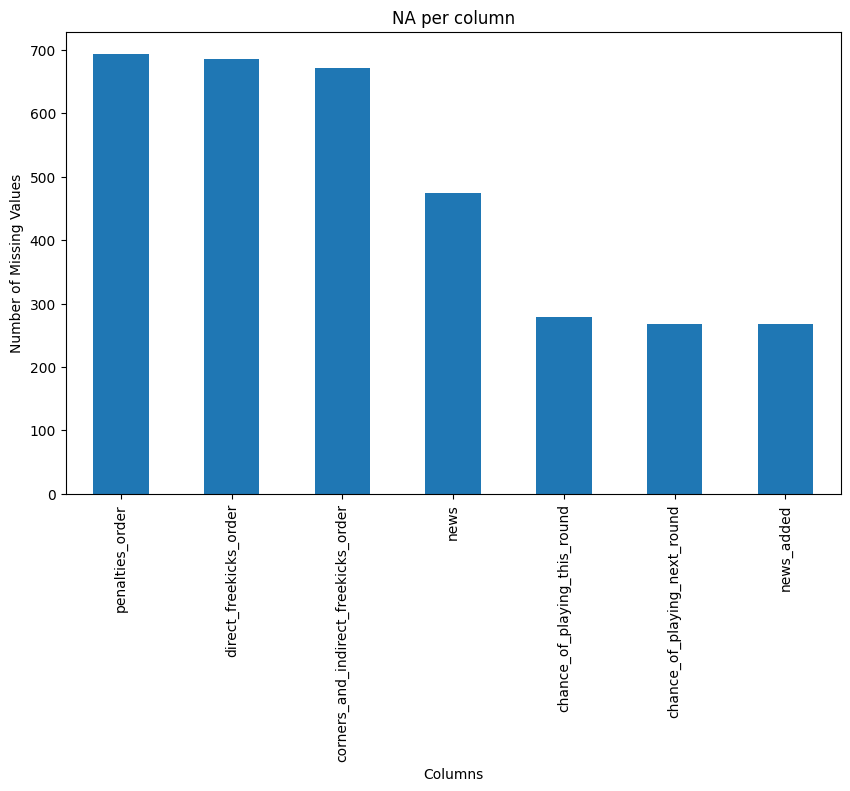

In [99]:
features_missing_values.plot(kind = 'bar', figsize = (10,6))
plt.title("NA per column")
plt.xlabel("Columns")
plt.ylabel("Number of Missing Values")
plt.show()

It looks like there are NAs in only 7 columns - **penalties_order**; **direct_freekicks_order**; **corners_and_indirect_freekicks_order**; **news**; **chance_of_playing_this_round**; **chance_of_playing_next_round**; **news_added**

## Data preparation

Below we can find a description of every column that has NAs. In this way we will decide how to proceed with the NAs:

- **penalties_order** - Order of penalties taken by the player.
- **direct_freekicks_order** - Order of direct freekicks taken by the player.
- **corners_and_indirect_freekicks_order** - Order of corners and indirect freekicks taken by the player.
- **news** -  News about the player.
- **chance_of_playing_this_round** - Likelihood of the player playing in the current round.
- **chance_of_playing_next_round** - Likelihood of the player playing in the next round.
- **news_added** - Date when news about the player was added.

The following columns will be dropped:

**penalties_order**, **direct_freekicks_order**, **corners_and_indirect_freekicks_order**, **news** and **news_added**

The NAs in **chance_of_playing_this_round** and **chance_of_playing_next_round** will be replaced with 0.



In [100]:
players = players.drop(columns = ["penalties_order", "direct_freekicks_order", "corners_and_indirect_freekicks_order", "news", "news_added"])

In [101]:
players.shape

(743, 74)

The columns have been dropped successfully.

In [102]:
players = players.fillna(value = 0)

In [103]:
players.isna().values.any()

False

There are no NA values in our data anymore. We can proceed with splitting the data.

Our target column (labels) is going to be **ep_next** -  Expected points for the next match.

In [104]:
attributes = players.drop(columns = "ep_next")
labels = players.ep_next



In [105]:
def calculate_entropy(column):
  frequencies = column.value_counts()
  probabilities = frequencies/len(column)
  entropy = -np.sum(probabilities*np.log2(probabilities))
  return entropy

features_list = []

for col in attributes:
  entropy = calculate_entropy(attributes[col])
  features_list.append({"Column": col, "Entropy": entropy})

features_list = pd.DataFrame(features_list)

features_list = features_list.sort_values(by = ["Entropy"], ascending = [False])

features_list

,Column,Entropy
0,id,9.537218
17,influence_rank,9.537218
54,now_cost_rank,9.537218
53,form_rank,9.537218
39,threat_rank,9.537218
...,...,...
46,red_cards,0.225248
52,own_goals,0.172052
27,in_dreamteam,0.111181
31,penalties_missed,0.037922


In [106]:
attributes_train, attributes_test, labels_train, labels_test = train_test_split(attributes, labels, test_size = 0.2)

In [107]:
attributes_train.shape, attributes_test.shape, labels_train.shape, labels_test.shape

((594, 73), (149, 73), (594,), (149,))

In [108]:
numeric_train = attributes_train.select_dtypes(exclude = "object").columns
categorical_train = attributes_train.select_dtypes(include = "object").columns

preprocessor = ColumnTransformer(
    transformers = [
        ("ohe", OneHotEncoder(handle_unknown = "ignore", sparse_output = False), categorical_train),
        ("num", MinMaxScaler(), numeric_train)
    ],
    remainder = "passthrough"
)

preprocessor.set_output(transform="pandas")

attributes_train = preprocessor.fit_transform(attributes_train)

attributes_test = preprocessor.transform(attributes_test)

Everything looks fine. We are going to proceed with preprocessing only our training set - in this way we are preventing any data leakage.

In [109]:
attributes_train.shape, attributes_test.shape

((594, 1270), (149, 1270))

In [110]:
attributes_train

ohe__name_Aaron Connolly  ohe__name_Aaron Cresswell  \
331                       0.0                        0.0   
662                       0.0                        0.0   
386                       0.0                        0.0   
487                       0.0                        0.0   
698                       0.0                        0.0   
..                        ...                        ...   
276                       0.0                        0.0   
332                       0.0                        0.0   
322                       0.0                        0.0   
124                       0.0                        0.0   
575                       0.0                        0.0   

     ohe__name_Aaron Hickey  ohe__name_Aaron Ramsdale  ohe__name_Aaron Ramsey  \
331                     0.0                       0.0                     0.0   
662                     0.0                       0.0                     0.0   
386                     0.0                       0.0                     0.0   
487                     0.0                       0.0                     0.0   
698                     0.0                       0.0                     0.0   
..                      ...                       ...                     ...   
276                     0.0                       0.0                     0.0   
332                     0.0                       0.0                     0.0   
322                     0.0                       0.0                     0.0   
124                     0.0                       0.0                     0.0   
575                     0.0                       0.0                     0.0   

     ohe__name_Aaron Wan-Bissaka  ohe__name_Abdoulaye Doucouré  \
331                          0.0                           0.0   
662                          0.0                           0.0   
386                          0.0                           0.0   
487                          0.0                           0.0   
698                          0.0                           0.0   
..                           ...                           ...   
276                          0.0                           0.0   
332                          0.0                           0.0   
322                          0.0                           0.0   
124                          0.0                           0.0   
575                          0.0                           0.0   

     ohe__name_Abdul Rahman Baba  ohe__name_Adam Davies  \
331                          0.0                    0.0   
662                          0.0                    0.0   
386                          0.0                    0.0   
487                          0.0                    0.0   
698                          0.0                    0.0   
..                           ...                    ...   
276                          0.0                    0.0   
332                          0.0                    0.0   
322                          0.0                    0.0   
124                          0.0                    0.0   
575                          0.0                    0.0   

     ohe__name_Adam Lallana  ohe__name_Adam Smith  ohe__name_Adam Webster  \
331                     0.0                   0.0                     0.0   
662                     0.0                   0.0                     0.0   
386                     0.0                   0.0                     0.0   
487                     0.0                   0.0                     0.0   
698                     0.0                   0.0                     0.0   
..                      ...                   ...                     ...   
276                     0.0                   0.0                     0.0   
332                     0.0                   0.0                     0.0   
322                     0.0                   0.0                     0.0   
124                     0.0            

In [59]:
attributes_train = pd.DataFrame(attributes_train, sep = '\t')

attributes_train

TypeError: DataFrame.__init__() got an unexpected keyword argument 'sep'

As wee see our training set and test set have different numbers of columns - this is most probably because of many unique values. I will resolve this problem by doing the OHE before train_test_split. I know this is not the optimal thing to do, because of data leakage.

Okay we have our data ready. Let's try our firts model - Linear Regression.

In [ ]:
print(attributes_test)

  (0, 597)	1.0
  (0, 610)	1.0
  (0, 1198)	1.0
  (0, 1199)	0.46693657219973006
  (0, 1200)	0.0594059405940594
  (0, 1201)	0.025974025974025976
  (0, 1203)	0.024793388429752063
  (0, 1205)	0.5
  (0, 1206)	0.75625
  (0, 1209)	0.41666666666666663
  (0, 1213)	0.871967654986523
  (0, 1216)	0.734375
  (0, 1219)	6.847236778034691e-06
  (0, 1220)	0.8665768194070081
  (0, 1222)	0.809375
  (0, 1225)	0.5833333333333333
  (0, 1231)	0.8800539083557952
  (0, 1232)	0.8852901484480431
  (0, 1233)	0.5
  (0, 1234)	0.8530997304582211
  (0, 1235)	0.07272727272727274
  (0, 1237)	0.81875
  (0, 1245)	0.79375
  (0, 1246)	0.80625
  (0, 1248)	0.8218623481781376
  :	:
  (148, 1213)	0.9609164420485176
  (148, 1216)	0.909375
  (148, 1219)	0.00021089489276346845
  (148, 1220)	0.9568733153638815
  (148, 1222)	0.946875
  (148, 1225)	0.5833333333333333
  (148, 1231)	0.9609164420485176
  (148, 1232)	0.9608636977058029
  (148, 1233)	0.5
  (148, 1234)	0.9528301886792454
  (148, 1235)	0.07272727272727274
  (148, 1237)	0.95

## Algorithm Evaluation

### Linear Regression

In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(attributes_train, labels_train)

ValueError: could not convert string to float: 'Pervis Estupiñán'

In [ ]:
y_pred = linear_regression.predict(attributes_train)
np.sqrt(mean_squared_error(labels_train, y_pred))

1.255360909208326e-05

In [ ]:
linear_regression.score(attributes_train, labels_train)

0.9999999999451389

In [ ]:
y_pred_test = linear_regression.predict(attributes_test)
np.sqrt(mean_squared_error(labels_test, y_pred_test))

0.7224336438948742

In [ ]:
linear_regression.score(attributes_test,labels_test)

0.8117347424856254

It looks like our model overfitted our training set. Maybe it learned the data by heart. We see that it does not perform really well on our test set

We are going to apply Regularization to simplify or model. In this case I will set some coefficients to 0 using the Lasso:

### Lasso

In [ ]:
lasso = Lasso(alpha = 0.01)
lasso.fit(attributes_train,labels_train)

Lasso(alpha=0.01)

In [ ]:
lasso.score(attributes_train, labels_train)

0.8745343331911544

In [ ]:
y_pred_lasso = lasso.predict(attributes_train)
np.sqrt(mean_squared_error(labels_train, y_pred_lasso))

0.600342196582947

In [ ]:
lasso.score(attributes_test, labels_test)

0.8439698785719645

In [ ]:
y_pred_lasso = lasso.predict(attributes_test)
np.sqrt(mean_squared_error(labels_test, y_pred_lasso))

0.6576837248499369

We see that Lasso perform more consistant than the Linear Regression

### Support Vector Machines (SVM)

In [ ]:
svm = SVR()
svm.fit(attributes_train, labels_train)

SVR()

In [ ]:
svm.score(attributes_train, labels_train)

0.7750292954986127

In [ ]:
y_pred_svm = svm.predict(attributes_train)
np.sqrt(mean_squared_error(labels_train, y_pred_svm))

0.803895142650759

In [ ]:
svm.score(attributes_test, labels_test)

0.6027803804162044

In [ ]:
y_pred_svm = svm.predict(attributes_test)
np.sqrt(mean_squared_error(labels_test, y_pred_svm))

1.0493689683246383

We see that SVM is the model that performs worst by far - it has high bias.
Let's use GridSearhCV and see if we can achive a better result from SVM.

In [ ]:
params = {
    "C" : [1e3, 1e9, 1e12],
    "kernel" : ["linear"]
          }

grid_s = GridSearchCV(SVR(), param_grid = params)

In [ ]:
grid_s.fit(attributes_train, labels_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1000.0, 1000000000.0, 1000000000000.0],
                         'kernel': ['linear']})

In [ ]:
grid_s.score(attributes_train, labels_train)

0.997000067416618

In [ ]:
y_pred_grid = grid_s.predict(attributes_train)
np.sqrt(mean_squared_error(labels_train, y_pred_grid))

0.09283081598135555

In [ ]:
grid_s.score(attributes_test, labels_test)

0.806484379310264

In [ ]:
y_pred_grid = grid_s.predict(attributes_test)
np.sqrt(mean_squared_error(labels_test, y_pred_grid))

0.732438028989042

In [ ]:
grid_s.best_estimator_

SVR(C=1000.0, kernel='linear')

Hmm... Now SVM gives us a better result with C = 1e3. But there is a high variance - the training set is overfitted, but it could not quite perform as well on the test set.



### Random Forest

In [ ]:
rf = RandomForestRegressor()
rf.fit(attributes_train, labels_train)

RandomForestRegressor()

In [ ]:
rf.score(attributes_train, labels_train)

0.9676298900315149

In [ ]:
y_pred_rf = grid_s.predict(attributes_train)
np.sqrt(mean_squared_error(labels_train, y_pred_rf))

0.09283081598135555

In [ ]:
rf.score(attributes_test, labels_test)

0.8508630679633924

In [ ]:
y_pred_rf = grid_s.predict(attributes_test)
np.sqrt(mean_squared_error(labels_test, y_pred_rf))

0.732438028989042

By far Rnadom Forest Regressor gives us the best score. Let's do a deeper research and play with the hyper parameters:

In [ ]:
params_rfr = {
    "n_estimators" : [10, 50, 100],
    "max_depth" : [10, 20, 30]
          }

grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid = params_rfr)

In [ ]:
grid_rfr.fit(attributes_train, labels_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [10, 50, 100]})

In [ ]:
grid_rfr.score(attributes_train, labels_train)

0.9712329727594627

In [ ]:
y_pred_grid_rf = grid_s.predict(attributes_train)
np.sqrt(mean_squared_error(labels_train, y_pred_grid_rf))

0.09283081598135555

In [ ]:
grid_rfr.score(attributes_test, labels_test)

0.8602417843451449

In [ ]:
y_pred_grid_rf = grid_s.predict(attributes_test)
np.sqrt(mean_squared_error(labels_test, y_pred_grid_rf))

0.732438028989042

In [ ]:
grid_rfr.best_estimator_

RandomForestRegressor(max_depth=20)

We see that after the Grid Search our Random Forest gave us slightly better results.

## Result Presentation

As we see Random Forest Regressor has the best result - scoring roughly 96% on the training set and 85% on the test set. While there is much more space for improvement - for example feature selection and feature engineering I am delighted of the results as for now.